In [1]:
!pip install -q transformers

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install --upgrade ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 KB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q peft

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm as tqdm
from PIL import Image
import time

In [5]:
import os
import zipfile

def unzip_file(zip_path, extract_path):
    # Проверка, существует ли ZIP-файл
    if not os.path.isfile(zip_path):
        print(f"ZIP файл не найден: {zip_path}")
        return

    # Создание директории для извлечения, если она не существует
    os.makedirs(extract_path, exist_ok=True)

    # Распаковка ZIP-файла
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(extract_path)
        print(f"ZIP файл успешно распакован в {extract_path}")

# Пример использования
zip_file_path = 'output.zip'  # Замените на путь к вашему ZIP-файлу
output_folder = 'Images_final'  # Замените на путь к папке для распаковки

unzip_file(zip_file_path, output_folder)

ZIP файл успешно распакован в Images_final


In [2]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
#model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/home/user/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
path = "ready2train10000.csv"
num_samples = 10000
preready_dataset = (pd.read_csv(path))[:num_samples]
del preready_dataset['Unnamed: 0']
preready_dataset.iloc[[50]]

,image,caption
50,007d97e52d6da9ed8fc0eeb8cf4aab84.jpg,HHG Kacamata Thug Life Double Mosaic Sunglasse...


In [4]:
import os

im_arr = os.listdir(path="Images_final/")
len(im_arr)

10000

In [5]:
train_set = preready_dataset[:int(0.8*num_samples)]
val_set = preready_dataset[int(0.8*num_samples):]

train_set = train_set.reset_index()
del train_set['index']
val_set = val_set.reset_index()
del val_set['index']

len(train_set), len(val_set)

(8000, 2000)

In [6]:
class BLIPTunningDataset(Dataset):
  def __init__(self, data, processor):
    self.data = data
    self.processor = processor

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data.iloc[[idx]]
    image = Image.open(f"Images_final/{item['image'][idx]}")
    caption = item['caption'][idx]
    encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt")
    encoding = {k:v.squeeze() for k,v in encoding.items()}
    return encoding

In [7]:
train_dataset = BLIPTunningDataset(train_set, processor)
val_dataset = BLIPTunningDataset(val_set, processor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

len(train_dataloader), len(val_dataloader)

(500, 125)

In [8]:
config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0.10,
    bias="none",
    target_modules='all-linear'
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 13,436,800 || all params: 260,850,876 || trainable%: 5.1511


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

num_epochs = 20

In [10]:
train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    model.train()
    print("------------------------------------------------------------------------")
    print(f"Epoch: {epoch}")
    start_timepoint = time.time()
    train_loss = 0
    val_loss = 0

    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
    
        loss = outputs.loss
        train_loss += loss.item() / len(train_dataloader)


        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(f"Train loss: {train_loss}")
    train_loss_arr.append(train_loss)
  
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
    
            loss = outputs.loss
            val_loss += loss.item() / len(val_dataloader)
    print("Val loss:", val_loss)
    val_loss_arr.append(val_loss)
    end_timepoint = time.time()
    print(f"Time spent per epoch: {end_timepoint-start_timepoint}")
    print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Train loss: 2.834901602625841
Val loss: 0.188395404100418
Time spent per epoch: 708.2201373577118
------------------------------------------------------------------------
------------------------------------------------------------------------
Epoch: 1
Train loss: 0.17677638179063793
Val loss: 0.17124046653509137
Time spent per epoch: 709.4704930782318
------------------------------------------------------------------------
------------------------------------------------------------------------
Epoch: 2
Train loss: 0.16431988807022577
Val loss: 0.16264417767524722
Time spent per epoch: 708.4514873027802
------------------------------------------------------------------------
------------------------------------------------------------------------
Epoch: 3
Train loss: 0.15448364987969412
Val loss: 0.15973440152406698
Time spent per epoch: 708.7474780082703
------------------------------------------------------------------------
----------------------------------------------------------

In [11]:
model.save_pretrained('training/caption')

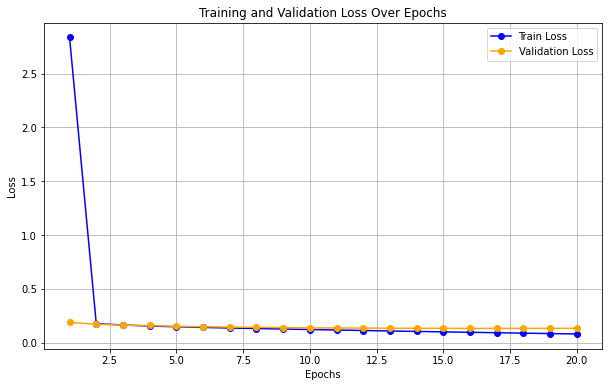

In [12]:
def plot_losses(train_loss_arr, val_loss_arr):
    # Определяем количество эпох (длина массивов)
    epochs = range(1, len(train_loss_arr) + 1)
    
    # Создаем график
    plt.figure(figsize=(10, 6))
    
    # График тренировочного лосса
    plt.plot(epochs, train_loss_arr, label='Train Loss', color='blue', marker='o')
    
    # График валидационного лосса
    plt.plot(epochs, val_loss_arr, label='Validation Loss', color='orange', marker='o')
    
    # Добавляем заголовки и метки осей
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Легенда
    plt.legend(loc='best')
    
    # Отображаем график
    plt.grid(True)
    plt.show()

plot_losses(train_loss_arr, val_loss_arr)

In [3]:
model = BlipForConditionalGeneration.from_pretrained('training/caption')

/usr/lib/python3/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


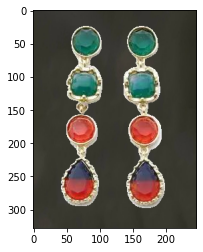

In [4]:
input_image = Image.open("img_with_applied_mask.png")
plt.imshow(input_image)
plt.show()

In [5]:
# prepare image for the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
inputs = processor(images=input_image, return_tensors="pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=200)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

bdn kalung gem dan kunci dan kunci


In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("google/madlad400-3b-mt")
tokenizer = AutoTokenizer.from_pretrained("google/madlad400-3b-mt")

inputs = tokenizer("<2en> bdn kalung gem dan kunci dan kunci", return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

/home/user/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Bdn gem necklace and keys and keys']
